# Interferometry results analysis for time-correlated random noises

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from html.entities import entitydefs

foldername = './Green_funs_for_different_models/'
Nmodel=4; Ns = 2526                                                                  # Number of model
Nx=501; Nz=501; dx=0.01; dz=0.01;                                                    # Mesh size and spacing  
Nt=3000; nt = Nt;  dt=0.002    

# Parametes used to simulate ambient noises
delta= 0.002                               # Time sampling interval (s)
hour = 2*3600                              # Recording time : 2 hour
autoc_winlen = int(hour/delta)             # Samping numbers
autoc_len    = int(6/delta)                # Time window (6 s) to calculate cross-correlation functions
nstack       = int(hour/6)                 # Stacking numbers

seis_len     = 3000

In [3]:
GreenA = np.zeros([Ns,Nt])
GreenB = np.zeros([Ns,Nt])

tmpdata = np.fromfile(foldername+'GreenA_'+'homogeneous'+'.dat', dtype=np.float32) 
tmpdata.shape=(Ns, Nt); GreenA = tmpdata
tmpdata = np.fromfile(foldername+'GreenB_'+'homogeneous'+'.dat', dtype=np.float32) 
tmpdata.shape=(Ns, Nt); GreenB = tmpdata

In [5]:
import math
Nshift=8

fm=20
dt=0.002
timedelay = int(1/20/dt)*25              

GreenA2 = np.zeros((Nshift,Ns,nt))
GreenB2 = np.zeros((Nshift,Ns,nt))
for iv in range (0,Nshift):
    shiftnt = timedelay+(iv*10)
    for it in range(0,int(nt/2)):
        GreenA2[iv,:,it+shiftnt] = GreenA[:,it]
        GreenB2[iv,:,it+shiftnt] = GreenB[:,it]

GreenA2=0.4*GreenA2+GreenA[0]
GreenB2=0.4*GreenB2+GreenB[0] 

In [9]:

shiftnoiseA = np.zeros((Nshift, autoc_winlen))
shiftnoiseB = np.zeros((Nshift, autoc_winlen))

# for ir in range(0, int(ns)):
#     print(ir,int(ns),ir/ns)

#     for im in range(0,Nshift):
#         ampli   = np.random.randn(autoc_winlen)
#         randomtmp   = np.convolve(ampli, GreenA2[im,ir], mode='same')
#         shiftnoiseA[im] = shiftnoiseA[im] + randomtmp
#         randomtmp   = np.convolve(ampli, GreenB2[im,ir], mode='same')
#         shiftnoiseB[im] = shiftnoiseB[im] + randomtmp
        
# np.float32(shiftnoiseA).tofile('./Data/ShiftnoiseA'+'.dat')
# np.float32(shiftnoiseB).tofile('./Data/ShiftnoiseB'+'.dat')

#Time cost for random noises simulation is heavy you can directly read in data with:
tmpdata = np.fromfile(foldername+'ShiftnoiseA'+'.dat', dtype=np.float32) 
tmpdata.shape=(Nshift, autoc_winlen); shiftnoiseA = tmpdata
tmpdata = np.fromfile(foldername+'ShiftnoiseB'+'.dat', dtype=np.float32) 
tmpdata.shape=(Nshift, autoc_winlen); shiftnoiseB = tmpdata

In [10]:
nauto     = int(autoc_len) 
shift_allAB = np.zeros((Nshift,nauto))

overlap_len    = int(0.05/delta)
nstack       = int(hour/0.05)
nshow        = 1200

ifwhiten = 0
Nw_frac = 5
epsilon = 1e-10


for iv in range(0,Nshift):
    ist=0
    for iit in range(0, nstack):
        
    #ntime stacks 
    # slice out the data within a short window
        endtime = autoc_winlen
        win_bgn = iit*overlap_len 
        win_end = win_bgn+autoc_len
        st_sliceA = shiftnoiseA[iv, win_bgn:min(win_end,endtime)]
        st_sliceB = shiftnoiseB[iv, win_bgn:min(win_end,endtime)]                 
        
        if endtime < win_end:
            break
             
    # perform FFT
        spA = np.fft.fft(st_sliceA)
        spB = np.fft.fft(st_sliceB)
                
    # spectral whitening, if required
        if ifwhiten == 1:
            ampA = np.abs(spA)
            ampB = np.abs(spB)
            Nw = int((autoc_len)/Nw_frac)
            amp_smA = np.convolve(ampA, np.ones(Nw)/Nw, mode='same')
            amp_smB = np.convolve(ampB, np.ones(Nw)/Nw, mode='same')
            spA = spA / (amp_smA + epsilon*max(amp_smA))
            spB = spB / (amp_smB + epsilon*max(amp_smB))
                
    # calculate crosscorrelation fun in freq domain
        auto_funfAB = (spA*np.conj(spB)) 
        auto_funtAB = np.fft.ifft(auto_funfAB)
        tempAB = auto_funtAB.real[0: nauto]
        tempAB = tempAB / max(tempAB)
        shift_allAB[iv] = shift_allAB[iv] +tempAB

     #   print(iv, iit, nstack)
        
    shift_allAB[iv] = shift_allAB[iv]/(iit+1)
#print(nstack)

Text(0.5, 1.0, 'XCFs for homogeneous medium')

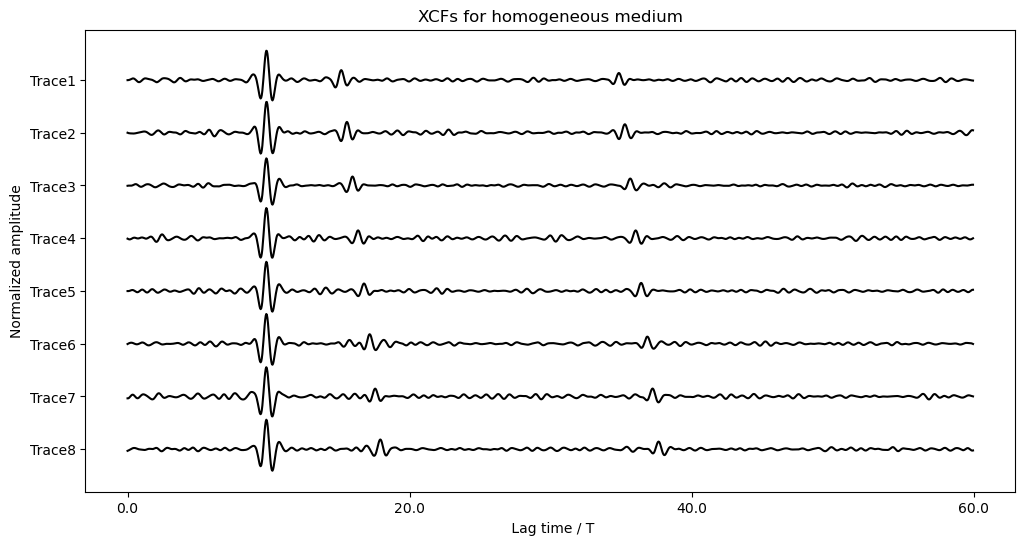

In [11]:
# For figure 11
fig_size = (12, 6)
fontsz = 14
ypos=np.arange(0,int(nt/2+1));yaxis = np.arange(nt/2+1)*0.002*20

f, ax = plt.subplots(1,1, figsize=fig_size)

for iv in range(0,8):
    ax.plot(shift_allAB[iv,0:1500]*5-(iv+1)*2,'k')#'#F97306')

ax.set_xticks(ypos[0:int(nt/2+1):int(nt/6)], labels=yaxis[0:int(nt/2+1):int(nt/6)])
ax.set_yticks([-2,-4,-6,-8,-10,-12,-14,-16], labels=['Trace1','Trace2','Trace3','Trace4','Trace5','Trace6','Trace7','Trace8'])
ax.set_ylabel('Normalized amplitude');ax.set_xlabel(' Lag time / T')
ax.set_title('XCFs for homogeneous medium')

Text(0.5, 1.0, 'XCFs for homogeneous medium')

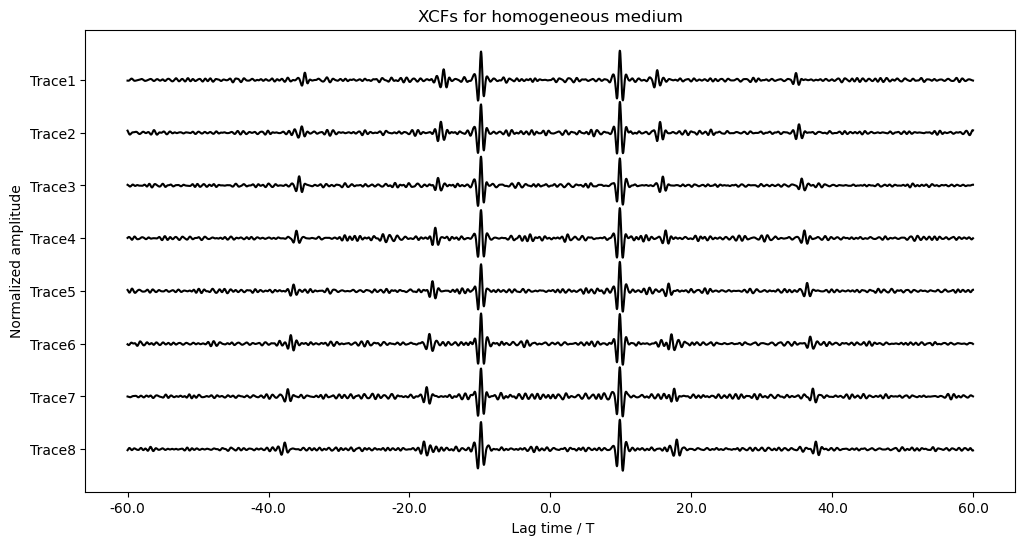

In [12]:
shift_allAB2 = np.zeros((Nshift,nauto))
shift_allAB2[:,0+int(nauto/2):1500+int(nauto/2)] = shift_allAB[:,0:1500]
shift_allAB2[:,0:1500] = shift_allAB[:,0+int(nauto/2):1500+int(nauto/2)]

fig_size = (12, 6)
fontsz = 14
ypos=np.arange(0,int(nt+1));yaxis = np.arange(nt+1)*0.002*20 - 60

f, ax = plt.subplots(1,1, figsize=fig_size)

for iv in range(0,8):
    ax.plot(shift_allAB2[iv,:]*5-(iv+1)*2,'k') #'#F97306')

ax.set_xticks(ypos[0:int(nt+1):int(nt/6)], labels=yaxis[0:int(nt+1):int(nt/6)])
ax.set_yticks([-2,-4,-6,-8,-10,-12,-14,-16], labels=['Trace1','Trace2','Trace3','Trace4','Trace5','Trace6','Trace7','Trace8'])
ax.set_ylabel('Normalized amplitude');ax.set_xlabel(' Lag time / T')
ax.set_title('XCFs for homogeneous medium')
#    ax.set_ylim(-0.8,1.2);ax.set_yticks([-0.5,0,0.5,1]) 
#plt.savefig('./Pic/Data/Timedelay-randomWaveshapeAB'+".png", bbox_inches='tight') 